# 1.数据预处理，主要处理原始数据为目标格式

1.实验MLP的准确率

2.实验VAE

3.实验GNN生成题目向量 

4.使用题目向量并非技能向量实验

5.训练图片和文本融合向量

6.不使用PNN算法训练向量，用最简单的方式训练看效果。

In [47]:
from EduData import get_data
get_data("assistment-2009-2010-skill", "data")
import random
import pandas as pd
import tqdm
import numpy as np

data = pd.read_csv(
    'data/2009_skill_builder_data_corrected/skill_builder_data_corrected.csv',
    usecols=['order_id', 'user_id', 'sequence_id', 'skill_id', 'correct','problem_id'],encoding="utf-8"
).dropna(subset=['skill_id'])
raw_skill = data.skill_id.unique().tolist()
raw_problem = data.problem_id.unique().tolist()

num_skill = len(raw_skill)
num_problem = len(raw_problem)

# question id from 0 to (num_skill - 1)
skills = { p: i for i, p in enumerate(raw_skill) }
problem = { p: i for i, p in enumerate(raw_problem) }

print("number of skills: %d" % num_skill)
print("number of problems: %d" % num_problem)
p_embedding = np.zeros((num_problem,num_skill))
for index, row in data.iterrows():
    p_id = problem[row['problem_id']]
    s_id = skills[row['skill_id']]
    p_embedding[p_id][s_id] = 1
def parse_all_seq(students):
    all_sequences = []
    for student_id in tqdm.tqdm(students, 'parse student sequence:\t'):
        student_sequence = parse_student_seq(data[data.user_id == student_id])
        all_sequences.extend([student_sequence])
    return all_sequences


def parse_student_seq(student):
    seq = student.sort_values('order_id')
    s = [skills[q] for q in seq.skill_id.tolist()]
    p = [problem[q] for q in seq.problem_id.tolist()]
    a = seq.correct.tolist()
    return s,p,a


# [(question_sequence_0, answer_sequence_0), ..., (question_sequence_n, answer_sequence_n)]
sequences = parse_all_seq(data.user_id.unique())

def train_test_split(data, train_size=1.0, shuffle=True):
    if shuffle:
        random.shuffle(data)
    boundary = round(len(data) * train_size)
    return data[: boundary], data[boundary:]


train_sequences, test_sequences = train_test_split(sequences)

MAX_STEP = 50

def encode_onehot(sequences, max_step):
    skill_result = []
    problem_result = []
    problem_embedding_result = []
    answer_result = []
    real_result = []
    for s, p, a in tqdm.tqdm(sequences, 'convert to one-hot format: '):
        s_len = len(s)
        left = MAX_STEP - s_len % MAX_STEP
        s = s + [0]*left
        p = p + [0]*left
        a = a + [0]*left
        last_real_len = s_len % MAX_STEP
        first_real_len = [MAX_STEP] * ((s_len - last_real_len) // MAX_STEP)
        real_len = first_real_len + [last_real_len]
        num = (s_len+left)//MAX_STEP
        skill_seq = []
        problem_seq = []
        answer_seq = []
        problem_embedding_seq = []
        for i in range(num):
            skill_seq.append(s[i*MAX_STEP:(i+1)*MAX_STEP])
            problem_seq.append(p[i*MAX_STEP:(i+1)*MAX_STEP])
            answer_seq.append(a[i*MAX_STEP:(i+1)*MAX_STEP])
            problem_embedding = []
            for index in s[i*MAX_STEP:(i+1)*MAX_STEP]:
                one_hot = [0]*num_skill
                if index != -1:
                    one_hot[index] = 1
                problem_embedding.append(one_hot)
            problem_embedding_seq.append(problem_embedding)
        skill_result.extend(skill_seq)
        problem_result.extend(problem_seq)
        answer_result.extend(answer_seq)
        problem_embedding_result.extend(problem_embedding_seq)
        real_result.extend(real_len)
    return np.array(skill_result),np.array(problem_result),np.array(answer_result),np.array(problem_embedding_result),np.array(real_result)


# reduce the amount of data for example running faster
percentage = 1.0
train_data = encode_onehot(train_sequences[: int(len(train_sequences) * percentage)], MAX_STEP)
test_data = encode_onehot(test_sequences[: int(len(test_sequences) * percentage)], MAX_STEP)


downloader, INFO http://base.ustc.edu.cn/data/ASSISTment/2009_skill_builder_data_corrected.zip is saved as data/2009_skill_builder_data_corrected.zip
downloader, INFO file existed, skipped


number of skills: 123
number of problems: 17751


convert to one-hot format: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4163/4163 [00:00<00:00, 5159.35it/s]
convert to one-hot format: : 0it [00:00, ?it/s]


## 1.1 存储数据
pro_skill_sparse.npz ----->  问题和技能的矩阵 

ass9.npz   ---->  学生行为数据

pro_feat.npz -----> 问题难度系数矩阵

In [48]:
from scipy import sparse
np.savez('whole_steps_data/ass9.npz',
        y=train_data[2],
         skill=train_data[0],
         problem=train_data[1],
         problem_embedding=p_embedding,
         real_len=train_data[4],
         skill_num=num_skill,
         problem_num=num_problem
        )
np.save('pro_skill_data',p_embedding)
sparse.save_npz('whole_steps_data/pro_skill_sparse.npz',sparse.coo_matrix(p_embedding))

difficult = np.zeros((num_problem,7))
for index, row in data.iterrows():
    p_id = problem[row['problem_id']]
    s_id = skills[row['skill_id']]
    difficult[p_id][-1] += row['correct']
    difficult[p_id][-2] += 1

difficult[:,-1] = difficult[:,-1] / difficult[:,-2]
difficult[:,-2]=0
difficult[:,-1]
sparse.save_npz('whole_steps_data/pro_feat.npz',sparse.coo_matrix(difficult))

## 1.2 生成题目知识点的关系稀疏矩阵

In [49]:
import os
import sys
import numpy as np
from scipy import sparse
import time


data_folder = 'whole_steps_data'
# pro_skill_coo = sparse.load_npz(os.path.join(data_folder, 'pro_skill_sparse.npz'))
pro_skill = np.load('pro_skill_data.npy')
[pro_num, skill_num] = pro_skill.shape
print('problem number %d, skill number %d' % (pro_num, skill_num))
pro_skill_csc = sparse.csc_matrix(pro_skill)
pro_skill_csr = sparse.csr_matrix(pro_skill)

def extract_pro_pro_sim():
    # extract pro-pro similarity sparse matrix
    pro_pro_adj = []
    for p in range(pro_num):
        tmp_skills = pro_skill_csr.getrow(p).indices
        similar_pros = pro_skill_csc[:, tmp_skills].indices
        zipped = zip([p] * similar_pros.shape[0], similar_pros)
        pro_pro_adj += list(zipped)

    pro_pro_adj = list(set(pro_pro_adj))
    pro_pro_adj = np.array(pro_pro_adj).astype(np.int32)
    data = np.ones(pro_pro_adj.shape[0]).astype(np.float32)
    pro_pro_sparse = sparse.coo_matrix((data, (pro_pro_adj[:, 0], pro_pro_adj[:, 1])), shape=(pro_num, pro_num))
    sparse.save_npz(os.path.join(data_folder, 'pro_pro_sparse.npz'), pro_pro_sparse)


def extract_skill_skill_sim():
    # extract skill-skill similarity sparse matrix
    skill_skill_adj = []
    for s in range(skill_num):
        tmp_pros = pro_skill_csc.getcol(s).indices
        similar_skills = pro_skill_csr[tmp_pros, :].indices
        zipped = zip([s] * similar_skills.shape[0], similar_skills)
        skill_skill_adj += list(zipped)

    skill_skill_adj = list(set(skill_skill_adj))
    skill_skill_adj = np.array(skill_skill_adj).astype(np.int32)
    data = np.ones(skill_skill_adj.shape[0]).astype(np.float32)
    skill_skill_sparse = sparse.coo_matrix((data, (skill_skill_adj[:, 0], skill_skill_adj[:, 1])), shape=(skill_num, skill_num))
    sparse.save_npz(os.path.join(data_folder, 'skill_skill_sparse.npz'), skill_skill_sparse)


extract_pro_pro_sim()
extract_skill_skill_sim()

problem number 17751, skill number 123


# 2. 题目向量预训练

In [83]:
def pnn1(inputs, embed_size, hidden_dim, keep_prob):
    num_inputs = len(inputs)
    num_pairs = int(num_inputs * (num_inputs - 1) / 2)
    xw = torch.cat(inputs, 1)
    xw3d = xw.view(-1, num_inputs, embed_size)
    row = []
    col = []
    for i in range(num_inputs - 1):
        for j in range(i + 1, num_inputs):
            row.append(i)
            col.append(j)
    p = xw3d[:, row, :].transpose(1, 0)
    q = xw3d[:, col, :].transpose(1, 0)
    p = p.contiguous().view(-1, num_pairs, embed_size)
    q = q.contiguous().view(-1, num_pairs, embed_size)
    ip = (p * q).sum(-1).view(-1, num_pairs)
    l = torch.cat([xw, ip], 1)
    h = nn.Linear(l.size(1), hidden_dim)(l)
    h = nn.ReLU()(h)
    h = nn.Dropout(p=1 - keep_prob)(h)
    p = nn.Linear(hidden_dim, 1)(h).view(-1)
    return h, p

import os
import torch
import numpy as np
import math
from scipy import sparse
from torch.nn import functional as F


import torch
import torch.nn as nn




# 加载数据
data_folder = 'whole_steps_data'
con_sym = ';'

pro_skill_coo = sparse.load_npz(os.path.join(data_folder, 'pro_skill_sparse.npz'))
skill_skill_coo = sparse.load_npz(os.path.join(data_folder, 'skill_skill_sparse.npz'))
pro_pro_coo = sparse.load_npz(os.path.join(data_folder, 'pro_pro_sparse.npz'))

pro_num, skill_num = pro_skill_coo.shape
print(f'问题数目{pro_num}, 技能数目{skill_num}')

pro_skill = pro_skill_coo.toarray()
pro_pro = pro_pro_coo.toarray()
skill_skill = skill_skill_coo.toarray()
pro_skill_tensor = torch.from_numpy(pro_skill)
skill_skill_tensor = torch.from_numpy(skill_skill)
pro_pro_tensor = torch.from_numpy(pro_pro)

pro_feat = sparse.load_npz(os.path.join(data_folder, 'pro_feat.npz')).toarray()
pro_feat_tensor = torch.from_numpy(pro_feat)
print('问题特征形状:', pro_feat.shape)

diff_feat_dim = pro_feat.shape[1] - 1
embed_dim = 64
hidden_dim = 64
dropout = 0.5
lr = 0.001
batch_size = 256
epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# 定义模型
class PEGB(torch.nn.Module):
    def __init__(self, pro_num, skill_num, diff_feat_dim, embed_dim):
        super(PEGB, self).__init__()

        self.pro_embeddings = torch.nn.Embedding(pro_num, embed_dim)
        self.skill_embeddings = torch.nn.Embedding(skill_num, embed_dim)
        self.diff_embeddings = torch.nn.Linear(diff_feat_dim, embed_dim)
        
        self.final_embedding = torch.zeros(pro_num, embed_dim)
    
    def final_pro_embedding(self):
        batch_pro = torch.arange(pro_num).long().to(device)
        batch_pro_skill = torch.Tensor(pro_skill).to(device)
        batch_pro_pro = torch.Tensor(pro_pro).to(device)
        batch_diff_feat = torch.Tensor(pro_feat[:,:-1]).to(device)
        batch_skill_skill = torch.arange(skill_num).to(device)
        pro_embed = self.pro_embeddings(batch_pro)
        skill_embed = self.skill_embeddings(batch_skill_skill)
        diff_feat_embed = self.diff_embeddings(batch_diff_feat)
        print(pro_embed.shape, skill_embed.shape, diff_feat_embed.shape)
        skill_embed = batch_pro_skill @ skill_embed / batch_pro_skill.sum(1, keepdim=True)
        h,p= pnn1([pro_embed, skill_embed, diff_feat_embed],embed_dim, hidden_dim, 0.5)
        return h



    def forward(self, pro, diff_feat, pro_skill, pro_pro, skill_skill):
        pro_embed = self.pro_embeddings(pro)
        skill_embed = self.skill_embeddings(skill_skill)
        diff_feat_embed = self.diff_embeddings(diff_feat)

        # pro-skill
        pro_skill_logits = (pro_embed @ skill_embed.t()).view(-1)
        pro_skill_loss = F.binary_cross_entropy_with_logits(pro_skill_logits, pro_skill.view(-1))

        # pro-pro
        pro_pro_logits = (pro_embed @ pro_embed.t()).view(-1)
        # print(pro_pro_logits.shape,pro_pro.shape)
        pro_pro_loss = F.binary_cross_entropy_with_logits(pro_pro_logits, pro_pro.contiguous().view(-1))

        # skill-skill
        skill_skill_logits = (skill_embed @ skill_embed.t()).view(-1)
        skill_skill_loss = F.binary_cross_entropy_with_logits(skill_skill_logits, skill_skill_tensor.view(-1))

        # 特征融合
        skill_embed = pro_skill @ skill_embed / pro_skill.sum(1, keepdim=True)
#         print(pro_embed.shape,skill_embed.shape,diff_feat_embed.shape)
        h,p= pnn1([pro_embed, skill_embed, diff_feat_embed],embed_dim, hidden_dim, 1.0)
#         h,p = self.pnn([pro_embed, skill_embed, diff_feat_embed])
        # pro_final_embed = None
#         print(p.shape,pro_feat_tensor.shape)
        self.final_embedding[pro] = h
        mse = ((p-diff_feat[:,-1])**2).mean()

        return pro_skill_loss, pro_pro_loss, skill_skill_loss,mse,h


model = PEGB(pro_num, skill_num, diff_feat_dim, embed_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def final_pro_embedding(self):
    batch_pro = torch.arange(pro_num).long().to(device)
    batch_pro_skill = torch.Tensor(pro_skill).to(device)
    batch_pro_pro = torch.Tensor(pro_pro).to(device)
    batch_diff_feat = torch.Tensor(pro_feat[:,:-1]).to(device)
    batch_skill_skill = torch.arange(skill_num).to(device)
    pro_embed = self.pro_embeddings(batch_pro)
    skill_embed = self.skill_embeddings(batch_skill_skill)
    diff_feat_embed = self.diff_embeddings(batch_diff_feat)
    print(pro_embed.shape, skill_embed.shape, diff_feat_embed.shape)
    skill_embed = batch_pro_skill @ skill_embed / batch_pro_skill.sum(1, keepdim=True)
    h,p= pnn1([pro_embed, skill_embed, diff_feat_embed],embed_dim, hidden_dim, 1.0)
    return h

问题数目17751, 技能数目123
问题特征形状: (17751, 7)


In [84]:
for epoch in range(1):
    model.train()
    train_loss = 0

    for i in range(0, pro_num, batch_size):
        batch_pro = torch.arange(i, min(i + batch_size, pro_num)).long().to(device)
        batch_pro_skill = torch.Tensor(pro_skill[i:i + batch_size]).to(device)
        batch_pro_pro = torch.Tensor(pro_pro[i:i + batch_size,i:i + batch_size]).to(device)
        batch_diff_feat = torch.Tensor(pro_feat[i:i + batch_size, :-1]).to(device)
        batch_skill_skill = torch.arange(skill_num).to(device)

        pro_skill_loss, pro_pro_loss, skill_skill_loss, mse,h = model(batch_pro,
                                                                  batch_diff_feat,
                                                                  batch_pro_skill,
                                                                  batch_pro_pro,
                                                                  batch_skill_skill)
        loss = pro_skill_loss + pro_pro_loss + skill_skill_loss + mse

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= math.ceil(pro_num / batch_size)
    print(f'Epoch {epoch}, Loss {train_loss:.4f}')

Epoch 0, Loss 9.5726


## 2.1可视化数据

/var/folders/z2/kds62tbj3x93zghv2_jz1xsr0000gn/T/ipykernel_63674/1348033428.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(class_data[:, 0], class_data[:, 1],c=color, label=str(label))


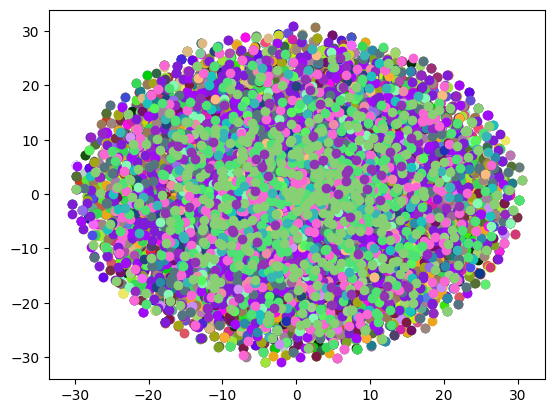

In [85]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 准备数据
# data_tensor = model.pro_embeddings.weight
data_tensor = model.pro_embeddings.weight

# 初始化t-SNE模型
tsne = TSNE(n_components=2, perplexity=30, learning_rate=100, n_iter=1000)

# 执行t-SNE降维
embedded_data = tsne.fit_transform(data_tensor.detach().numpy())

# 可视化结果
# plt.scatter(embedded_data[:, 0], embedded_data[:, 1])
for label in range(skill_num):
    pids = pro_skill_tensor[:,label].nonzero().view(-1).detach().numpy()
#     print(pids)
    red =  np.random.randint(0, 256)
    green = np.random.randint(0, 256)
    blue = np.random.randint(0, 256)
    color = (red / 255, green / 255, blue / 255)
    class_data = embedded_data[pids]
    plt.scatter(class_data[:, 0], class_data[:, 1],c=color, label=str(label))
plt.show()

In [87]:
np.save('whole_steps_data/skill_embedding.npy',model.skill_embeddings.weight.detach().numpy())
np.save('whole_steps_data/problem_embedding.npy',model.pro_embeddings.weight.detach().numpy())

# 3. DKT训练算法

In [88]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import metrics
from scipy import sparse
from tqdm import tqdm
import os
import time, math
train_flag = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_test_split(data, split=0.6):
    n_samples = data[0].shape[0]
    split_point = int(n_samples * split)
    train_data = [d[:split_point] for d in data]
    test_data = [d[split_point:] for d in data]
    return train_data, test_data


# 数据处理
data_folder = "whole_steps_data"
data = np.load(os.path.join(data_folder, 'ass9.npz'))
y, skill, problem, real_len = data['y'], data['skill'], data['problem'], data['real_len']
skill_num, pro_num = data['skill_num'], data['problem_num']
print('problem number %d, skill number %d' % (pro_num, skill_num))

# 划分训练集和测试集
train_data, test_data = train_test_split([y, skill, problem, real_len],split=0.7)
train_y, train_skill, train_problem, train_real_len = train_data
test_y, test_skill, test_problem, test_real_len = test_data

# 嵌入初始化
# embed_data = np.load(os.path.join(data_folder, 'embedding_200.npz'))
# _, _, pre_pro_embed = embed_data['pro_repre'], embed_data['skill_repre'], embed_data['pro_final_repre']
pre_pro_embed = np.load(os.path.join(data_folder, 'skill_embedding.npy'))
pro_num = skill_num

# 超参数
epochs = 200
bs = 64
embed_dim = pre_pro_embed.shape[1]
hidden_dim = 10
lr = 0.002
use_pretrain = True
train_embed = True

import torch

# 模型定义
class LSTM(nn.Module):
    def __init__(self, pro_num, embed_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.pro_embeddings = nn.Embedding(pro_num, embed_dim, padding_idx=0)
        # lstm_input_dim = embed_dim + 1
        self.lstm = nn.LSTM(embed_dim*2, hidden_dim, batch_first=True)
#         self.lstm = nn.Linear(embed_dim*2,hidden_dim)
        self.linear = nn.Linear(hidden_dim, pro_num)
        self.sigmoid = nn.Sigmoid()

        if use_pretrain:
            pretrained_weight = torch.from_numpy(pre_pro_embed)
            self.pro_embeddings.weight.data.copy_(pretrained_weight)
            self.pro_embeddings.weight.requires_grad = train_embed

    def forward(self, pro_seq, y_seq, pro_len):
        batch_size, seq_len = pro_seq.shape
        # 创建全零的张量
        zeros_tensor = torch.zeros(batch_size, seq_len, embed_dim)
        # 在指定维度进行拼接，生成需要填充的张量
        ones_tensor = torch.ones(batch_size,seq_len, embed_dim)
        zeros_filled = torch.cat([zeros_tensor, ones_tensor], dim=-1)
        # 根据 y_seq 创建索引张量
        y_indices = y_seq == 1
        # 使用索引张量填充对应位置
        pro_emb = zeros_filled.clone()
        pro_emb[y_indices] = torch.cat([torch.ones(embed_dim),torch.zeros(embed_dim)], dim=-1)
        pro_embeddings_x = self.pro_embeddings(pro_seq)
        pro_emb[:, :, :embed_dim] *= pro_embeddings_x
        pro_emb[:, :, embed_dim:] *= pro_embeddings_x
        # B T C ----> B T H
        lstm_out, (hn, cn) = self.lstm(pro_emb)
#         lstm_out = self.lstm(pro_emb)
        pred = self.linear(lstm_out)
        return self.sigmoid(pred)


model = LSTM(pro_num, embed_dim, hidden_dim).to(device)

# 损失函数和优化器
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def compute_metrics(preds, targets):
    auc = metrics.roc_auc_score(targets, preds)
    preds[preds > 0.5] = 1
    preds[preds <= 0.5] = 0
    acc = metrics.accuracy_score(targets, preds)
    return acc, auc


problem number 17751, skill number 123


In [89]:
if train_flag:

    train_steps = math.ceil(len(train_y) / bs)
    test_steps = math.ceil(len(test_y) / bs)

    best_auc = 0

    plot_data1 = []
    plot_data2 = []
    plot_data3 = []
    for epoch in range(epochs):

        model.train()
        train_loss = 0

        for i in tqdm(range(train_steps)):
            start = i * bs
            end = start + bs
            y_batch = torch.from_numpy(train_y[start:end]).float().to(device)
            # pro_batch = torch.from_numpy(train_problem[start:end]).long().to(device)
            pro_batch = torch.from_numpy(train_skill[start:end]).long().to(device)
            len_batch = torch.from_numpy(train_real_len[start:end]).long().to(device)
            apred = model(pro_batch, y_batch, len_batch)
            problem_ids = torch.cat([pro_batch[i, 1:l] for i, l in enumerate(len_batch)], dim=-1)
            pred = torch.cat([apred[i,:l-1] for i,l in enumerate(len_batch)],dim=0).gather(1,problem_ids.view(-1,1)).flatten()
            target = torch.cat([y_batch[i,1:l] for i,l in enumerate(len_batch)],dim=-1)
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= train_steps

        model.eval()
        test_preds, test_targets = [], []
        with torch.no_grad():
            for i in tqdm(range(test_steps)):
                start = i * bs
                end = start + bs
                y_batch = torch.from_numpy(test_y[start:end]).float().to(device)
                # pro_batch = torch.from_numpy(test_problem[start:end]).long().to(device)
                pro_batch = torch.from_numpy(test_skill[start:end]).long().to(device)
                len_batch = torch.from_numpy(test_real_len[start:end]).long().to(device)

                apred = model(pro_batch, y_batch, len_batch).squeeze(-1)
                problem_ids = torch.cat([pro_batch[i, 1:l ] for i, l in enumerate(len_batch)], dim=-1)
                pred = torch.cat([apred[i, :l-1] for i, l in enumerate(len_batch)], dim=0).gather(1,problem_ids.view(-1, 1)).flatten()
                target = torch.cat([y_batch[i, 1:l] for i, l in enumerate(len_batch)], dim=-1)
                test_preds.append(pred.detach().cpu().numpy())
                test_targets.append(target.detach().cpu().numpy())

        test_preds = np.concatenate(test_preds, axis=0)
        test_targets = np.concatenate(test_targets, axis=0)
        test_acc, test_auc = compute_metrics(test_preds, test_targets)

        print(
            f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.5f}, Test AUC: {test_auc:.3f}, Test ACC: {test_acc:.3f}')
        plot_data1.append(train_loss)
        plot_data2.append(test_auc)
        plot_data3.append(test_acc)

        if test_auc > best_auc:
            best_auc = test_auc
            torch.save(model.state_dict(), os.path.join(data_folder, 'dkt_pytorch.pt'))

else:
    model.load_state_dict(torch.load(os.path.join(data_folder, 'dkt_pytorch.pt')))
    model.eval()

    # 得到问题嵌入向量
    pro_embed_trained = model.pro_embeddings.weight.data[1:].cpu().numpy()
    np.savez(os.path.join(data_folder, 'pro_embed_pytorch.npz'), pro_final_repre=pro_embed_trained)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 191.33it/s]


Epoch 1/200, Train Loss: 0.63554, Test AUC: 0.706, Test ACC: 0.700


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 186.23it/s]


Epoch 2/200, Train Loss: 0.56173, Test AUC: 0.742, Test ACC: 0.720


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 189.11it/s]


Epoch 3/200, Train Loss: 0.53878, Test AUC: 0.754, Test ACC: 0.729


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 189.55it/s]


Epoch 4/200, Train Loss: 0.52929, Test AUC: 0.760, Test ACC: 0.733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 190.57it/s]


Epoch 5/200, Train Loss: 0.52349, Test AUC: 0.764, Test ACC: 0.735


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 192.55it/s]


Epoch 6/200, Train Loss: 0.51916, Test AUC: 0.767, Test ACC: 0.737


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 190.10it/s]


Epoch 7/200, Train Loss: 0.51570, Test AUC: 0.769, Test ACC: 0.739


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 190.76it/s]


Epoch 8/200, Train Loss: 0.51292, Test AUC: 0.770, Test ACC: 0.740


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 184.83it/s]


Epoch 9/200, Train Loss: 0.51063, Test AUC: 0.771, Test ACC: 0.740


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 179.31it/s]


Epoch 10/200, Train Loss: 0.50854, Test AUC: 0.772, Test ACC: 0.741


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 186.82it/s]


Epoch 11/200, Train Loss: 0.50675, Test AUC: 0.773, Test ACC: 0.741


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 187.00it/s]


Epoch 12/200, Train Loss: 0.50508, Test AUC: 0.774, Test ACC: 0.742


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 184.70it/s]


Epoch 13/200, Train Loss: 0.50356, Test AUC: 0.774, Test ACC: 0.743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 185.80it/s]


Epoch 14/200, Train Loss: 0.50218, Test AUC: 0.775, Test ACC: 0.743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 187.24it/s]


Epoch 15/200, Train Loss: 0.50090, Test AUC: 0.775, Test ACC: 0.743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 186.58it/s]


Epoch 16/200, Train Loss: 0.49970, Test AUC: 0.776, Test ACC: 0.743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 188.38it/s]


Epoch 17/200, Train Loss: 0.49865, Test AUC: 0.776, Test ACC: 0.743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 182.20it/s]


Epoch 18/200, Train Loss: 0.49766, Test AUC: 0.776, Test ACC: 0.743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 186.43it/s]


Epoch 19/200, Train Loss: 0.49668, Test AUC: 0.776, Test ACC: 0.743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 176.09it/s]


Epoch 20/200, Train Loss: 0.49575, Test AUC: 0.777, Test ACC: 0.744


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 184.47it/s]


Epoch 21/200, Train Loss: 0.49483, Test AUC: 0.777, Test ACC: 0.744


 59%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 61/103 [00:01<00:01, 33.58it/s]


KeyboardInterrupt: 

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# 初始化t-SNE模型
tsne = TSNE(n_components=2, perplexity=30, learning_rate=100, n_iter=1000)

# 执行t-SNE降维
embedded_data = tsne.fit_transform(pre_pro_embed)

# 可视化结果
# plt.scatter(embedded_data[:, 0], embedded_data[:, 1])
for label in range(skill_num):
#     pids = pro_skill_tensor[:,label].nonzero().view(-1).detach().numpy()
#     print(pids)
    red =  np.random.randint(0, 256)
    green = np.random.randint(0, 256)
    blue = np.random.randint(0, 256)
    color = (red / 255, green / 255, blue / 255)
    class_data = embedded_data[label]
#     print(class_data)
    plt.scatter(class_data[0], class_data[1],c=color, label=str(label))
plt.show()

In [9]:
# pretrain 0.712

In [6]:
pre_pro_embed.shape

(123, 64)

In [7]:
import matplotlib.pyplot as plt

# 示例数据
x = list(range(len(plot_data1)))
y_class1 = plot_data1
y_class2 = plot_data2
y_class3 = plot_data3

# 创建散点图
plt.scatter(x, y_class1, color='red', label='train_loss')
plt.scatter(x, y_class2, color='blue', label='Test AUC')
plt.scatter(x, y_class3, color='green', label='test_acc')

# 添加标题和坐标轴标签
plt.title('Scatter Plot with 3 Classes')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# 添加图例
plt.legend()

# 显示图表
plt.show()

NameError: name 'plot_data1' is not defined

In [30]:
y, skill, problem, real_len

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0]]),
 array([[37, 55, 45, ...,  0,  0,  0],
        [44,  0,  0, ...,  0,  0,  0],
        [32, 32, 32, ...,  0,  0,  0],
        ...,
        [ 0, 11,  0, ...,  0,  0,  0],
        [32, 32, 32, ..., 51, 51, 51],
        [51, 51, 47, ...,  0,  0,  0]]),
 array([[7408, 7408, 8287, ...,    0,    0,    0],
        [8156,    0,    0, ...,    0,    0,    0],
        [6111, 6022, 5952, ...,    0,    0,    0],
        ...,
        [  31,   31,    0, ...,    0,    0,    0],
        [6182, 6033, 6107, ..., 9736, 9663, 9757],
        [9719, 9759, 8694, ...,    0,    0,    0]]),
 array([ 24,   1,   8, ...,   2, 100,  11]))

# 基线模型用于对比

In [15]:
num_skill=123

In [29]:
class DKT(nn.Module):
    def __init__(self, pro_num, hidden_dim):
        super(DKT, self).__init__()
        self.lstm = nn.LSTM(pro_num*2, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, pro_num)
        self.sigmoid = nn.Sigmoid()

    def forward(self, pro_seq):
        # B sql_len embed_size
        lstm_out, (hn, cn) = self.lstm(pro_seq)
        pred = self.linear(lstm_out)
        return self.sigmoid(pred)

In [30]:
def encode_onehot(pro,answer,embed_size):
    length,seq_len = pro.shape
    res = np.zeros((length,seq_len,embed_size*2))
    for i in range(length):
        for j,(p,a) in enumerate(zip(pro[i],answer[i])):
            res[i][j][int(a)*embed_size+p] = 1
    return res      

In [31]:
one_hot_skill = encode_onehot(data['skill'],data['y'],num_skill)

In [32]:
my_train,my_test = train_test_split([y, one_hot_skill, data['skill'], real_len],split=0.95)

In [33]:
my_train_y, my_train_onehot_skill, my_train_problem, my_train_real_len = my_train
my_test_y, my_test_onehot_skill, my_test_problem, my_test_real_len = my_test

In [34]:
my_test_y.shape

(470, 50)

In [35]:
model = DKT(num_skill,10)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [36]:
my_train_onehot_skill_tensor = torch.from_numpy(my_train_onehot_skill).float()
my_train_y_tensor = torch.from_numpy(my_train_y).float()
my_train_problem_tensor = torch.from_numpy(my_train_problem)
my_train_real_len_tensor = torch.from_numpy(my_train_real_len)
def get_train_batch(batch_size = 64):
    i = np.random.randint(0,my_train_onehot_skill_tensor.shape[0]-batch_size-1)
    return my_train_onehot_skill_tensor[i:i+batch_size],\
           my_train_y_tensor[i:i+batch_size],\
           my_train_real_len_tensor[i:i+batch_size],my_train_problem_tensor[i:i+batch_size]



In [37]:
my_train_problem_tensor,my_train_real_len_tensor

(tensor([[ 97,  96,  96,  ...,   0,   0,   0],
         [ 49,  49,  49,  ...,   0,   0,   0],
         [ 32,  67,  66,  ...,  12,  98,  98],
         ...,
         [ 81,  81,  81,  ...,  98,  98,  98],
         [ 98,  98,  98,  ..., 121,   3, 121],
         [  3, 121,   3,  ...,  45,  45,  58]]),
 tensor([16, 20, 50,  ..., 50, 50, 50]))

In [38]:
def test_model():
    model.eval()
    with torch.no_grad():
        my_test_onehot_skill_tensor = torch.from_numpy(my_test_onehot_skill).float()
        print('xxx',my_test_onehot_skill_tensor.shape[0])
        my_test_y_tensor = torch.from_numpy(my_test_y).float()
        my_test_problem_tensor = torch.from_numpy(my_test_problem)
        my_test_real_len_tensor = torch.from_numpy(my_test_real_len)
        pred = model(my_test_onehot_skill_tensor)
        problem_ids = torch.cat([my_test_problem_tensor[i, 1:l] for i, l in enumerate(my_test_real_len_tensor)], dim=-1)
        pred = torch.cat([pred[i,:l-1] for i,l in enumerate(my_test_real_len_tensor)],dim=0).gather(1,problem_ids.view(-1,1)).flatten()
        target = torch.cat([my_test_y_tensor[i,1:l] for i,l in enumerate(my_test_real_len_tensor)],dim=-1)
        test_acc, test_auc = compute_metrics(pred.detach().numpy(), target.detach().numpy())
        print(sum(pred == target)/len(pred))
        print(test_acc, test_auc)

In [39]:
def train_model():
    model.train()
    for i in range(100000):
        batch_pro,batch_y,batch_len,batch_pro_ids = get_train_batch()
#         print(batch_pro.shape,batch_len.shape)
        pred = model(batch_pro) # batch seql_len embedsize
        problem_ids = torch.cat([batch_pro_ids[i,1:l] for i, l in enumerate(batch_len)], dim=-1)
        pred = torch.cat([pred[i,:l-1] for i,l in enumerate(batch_len)],dim=0).gather(1,problem_ids.view(-1,1)).flatten()
        target = torch.cat([batch_y[i,1:l] for i,l in enumerate(batch_len)],dim=-1)
        loss = criterion(pred, target)
        if i % 100 == 0:
            print(loss)
            test_model()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [40]:
train_model()

tensor(0.6903, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.5425)
0.5424727182539683 0.5067044716399985
tensor(0.6397, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.6690)
0.6690228174603174 0.6560222209230899
tensor(0.5137, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7015)
0.7015128968253969 0.7279785031152354
tensor(0.5569, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7253)
0.7253224206349206 0.7599163869368923
tensor(0.5097, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7369)
0.7368551587301587 0.7765672505019714
tensor(0.5637, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7436)
0.7436135912698413 0.786523757126572
tensor(0.5416, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7516)
0.7516121031746031 0.7928235068162273
tensor(0.5083, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7519)
0.751922123015873 0.7973059849497626
tensor(0.5000, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7586)
0.758

tensor(0.4761, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7725)
0.7725074404761905 0.8220726221693684
tensor(0.3906, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7722)
0.7721974206349206 0.8222382336278222
tensor(0.4945, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7728)
0.7728174603174603 0.8225331424289859
tensor(0.4737, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7721)
0.7721354166666666 0.8221577346864413
tensor(0.4642, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7723)
0.7722594246031746 0.8224971632370662
tensor(0.6604, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7736)
0.7735615079365079 0.8222427969649404
tensor(0.6032, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7728)
0.7728174603174603 0.8211799078326475
tensor(0.4214, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7729)
0.7729414682539683 0.8217085013597321
tensor(0.4546, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7724)
0.7

tensor(0.4771, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7725)
0.7725074404761905 0.8225743631787693
tensor(0.4371, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7701)
0.7700892857142857 0.8219498642143456
tensor(0.4019, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7731)
0.7730654761904762 0.8218278095993556
tensor(0.4677, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7718)
0.7718253968253969 0.8223732079293684
tensor(0.5079, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7718)
0.7718253968253969 0.8222989469442312
tensor(0.4733, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7724)
0.7723834325396826 0.8223200890106954
tensor(0.4527, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7715)
0.771453373015873 0.8221627669169145
tensor(0.4441, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7726)
0.7726314484126984 0.8224986201557057
tensor(0.4426, grad_fn=<BinaryCrossEntropyBackward0>)
xxx 470
tensor(0.7724)
0.77

KeyboardInterrupt: 

In [145]:
test_model()

0.6299343489605252 0.5512794848856535


In [199]:
batch_pro,batch_y,batch_len,batch_pro_ids = get_train_batch(1)
pred = model(batch_pro) # batch seql_len embedsize
problem_ids = torch.cat([batch_pro_ids[i, 1:l] for i, l in enumerate(batch_len)], dim=-1)
xx = torch.cat([pred[i,:l-1] for i,l in enumerate(batch_len)],dim=0)
pred = xx.gather(1,problem_ids.view(-1,1)).flatten()
target = torch.cat([batch_y[i,1:l] for i,l in enumerate(batch_len)],dim=-1)

In [211]:
xx

tensor([[0.5784, 0.3093, 0.4274,  ..., 0.4394, 0.3923, 0.7808],
        [0.0808, 0.4730, 0.8160,  ..., 0.9254, 0.7673, 0.4996],
        [0.5155, 0.3578, 0.9657,  ..., 0.8804, 0.9724, 0.9016],
        ...,
        [0.8033, 0.9218, 0.8277,  ..., 0.4568, 0.0389, 0.6514],
        [0.9643, 0.8965, 0.8835,  ..., 0.1630, 0.6984, 0.1740],
        [0.7210, 0.9311, 0.7384,  ..., 0.5283, 0.0255, 0.3851]],
       grad_fn=<CatBackward0>)

In [212]:
problem_ids

tensor([95, 95, 95, 95, 95, 95, 92, 92, 91, 91, 92, 91, 92, 33, 33, 33, 33, 33,
        33, 32, 33, 32, 32, 33, 32, 33, 33, 32, 98, 98, 98, 98, 98, 98, 98, 98,
        98, 98, 98, 48, 48, 48, 48, 48, 48, 48, 48, 98, 98, 98, 98, 98, 98, 98,
        98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99,
        99, 99, 63, 63, 99, 99, 99, 99, 99, 99, 18, 17, 21, 20, 20, 20, 20, 20,
        20, 67, 20, 20, 20, 20, 20, 20, 20])

In [206]:
target

tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0.])

In [207]:
pred

tensor([0.3992, 0.9921, 0.9816, 0.8837, 0.9203, 0.9314, 1.0000, 1.0000, 0.0845,
        0.0120, 0.9998, 0.9612, 0.9897, 0.9934, 0.9505, 0.9846, 0.9940, 0.9833,
        0.9914, 0.9925, 0.9983, 0.9684, 0.9832, 0.9694, 0.9745, 0.9982, 0.9743,
        0.9984, 0.7131, 0.7640, 0.6892, 0.7448, 0.4917, 0.6756, 0.6708, 0.7660,
        0.5738, 0.8434, 0.8020, 0.7930, 0.7173, 0.6536, 0.9034, 0.8727, 0.9239,
        0.9820, 0.9409, 0.7074, 0.7518, 0.9329, 0.5431, 0.7806, 0.5628, 0.8150,
        0.9379, 0.9133, 0.5923, 0.8819, 0.8346, 0.8341, 0.9460, 0.8997, 0.9100,
        0.7055, 0.6891, 0.9149, 0.8699, 0.8720, 0.6622, 0.9617, 0.9120, 0.9767,
        0.6256, 0.8704, 0.1312, 0.3226, 0.3388, 0.9034, 0.7281, 0.9868, 0.6658,
        0.9699, 0.6139, 0.7996, 0.9949, 0.2324, 0.5912, 0.2188, 0.8861, 0.8630,
        0.9838, 0.9938, 0.3115, 0.0277, 0.6039, 0.4976, 0.8877, 0.2430, 0.4981],
       grad_fn=<ReshapeAliasBackward0>)

In [176]:
problem_ids.shape

torch.Size([2851])

In [177]:
xx.shape

torch.Size([2851, 123])

In [179]:
xx.gather(1,problem_ids.view(-1,1))

tensor([[0.8458],
        [0.8938],
        [0.8595],
        ...,
        [0.0080],
        [0.2534],
        [0.0224]], grad_fn=<GatherBackward0>)

In [181]:
xx[1,81]

tensor(0.8938, grad_fn=<SelectBackward0>)

In [255]:
len(sequences)

4163

In [256]:
split_num = int(len(sequences)*0.95)
train_seq = sequences[:split_num]
test_seq = sequences[split_num:]

In [291]:
def get_train_seq_data(seq,length):
    for i in range(length):
        index = np.random.randint(0,len(seq)-1)
        s,p,a = seq[index]
        m = np.zeros((len(s),num_skill*2))
        for i,(si,ai) in enumerate(zip(s,a)):
            m[i][si+ai*num_skill] = 1
        yield torch.from_numpy(m).float(),torch.tensor(a).float(),torch.tensor(s)
            
            

In [296]:
def get_test_seq_data(seq):
    for i in range(len(seq)):
        s,p,a = seq[i]
        m = np.zeros((len(s),num_skill*2))
        for i,(si,ai) in enumerate(zip(s,a)):
            m[i][si+ai*num_skill] = 1
        yield torch.from_numpy(m).float(),torch.tensor(a).float(),torch.tensor(s)

In [282]:
for d in get_train_seq_data(train_seq,2):
    print(d)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
        1., 0., 1.]), tensor([97, 97, 97, 97, 97, 97, 97, 97, 97, 32, 33, 33, 33, 33, 33, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
        41, 41, 32, 33, 32, 33, 32, 33, 32, 33, 32, 33, 32, 33, 30, 30, 30, 30,
  

In [292]:
model = DKT(num_skill,10)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [299]:
for e in range(1000):
    model.train()
    preds = []
    answers = []
    for batch,answer,ss in get_train_seq_data(train_seq,64):
        pred = model(batch.unsqueeze(0)).squeeze(0)
        pred = pred[:len(answer)-1].gather(1,ss[1:].view(-1,1)).flatten()
        answer = answer[1:]
        preds.append(pred)
        answers.append(answer)
    preds = torch.cat(preds,dim=-1)
    answers = torch.cat(answers,dim=-1)
    loss = criterion(preds,answers)
    if e % 100 == 0:
        print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    model.eval()
    preds = []
    answers = []
    with torch.no_grad():
        for batch,answer,ss in get_test_seq_data(test_seq):
            pred = model(batch.unsqueeze(0)).squeeze(0)
            pred = pred[:len(answer)-1].gather(1,ss[1:].view(-1,1)).flatten()
            answer = answer[1:]
            preds.append(pred)
            answers.append(answer)
    preds = torch.cat(preds,dim=-1)
    answers = torch.cat(answers,dim=-1)
    test_acc, test_auc = compute_metrics(preds.detach().numpy(), answers.detach().numpy())
    if e % 100 == 0:
        print(test_acc, test_auc)

tensor(0.5021, grad_fn=<BinaryCrossEntropyBackward0>)
0.7582076758231054 0.6925297193394537
tensor(0.4680, grad_fn=<BinaryCrossEntropyBackward0>)
0.7589947399181765 0.6966760647346725
tensor(0.5282, grad_fn=<BinaryCrossEntropyBackward0>)
0.7595012663159946 0.699159026204437
tensor(0.4721, grad_fn=<BinaryCrossEntropyBackward0>)
0.7602415741281902 0.6982374037412991
tensor(0.4623, grad_fn=<BinaryCrossEntropyBackward0>)
0.7612156633547633 0.6979060036985311
tensor(0.5076, grad_fn=<BinaryCrossEntropyBackward0>)
0.7609351256575102 0.6998363411511216


KeyboardInterrupt: 